<a href="https://colab.research.google.com/github/czeacach/fashion_designers/blob/main/Analyse_nationalit%C3%A9s.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analyse des nationalités et leur évolution dans le temps

Dans ce carnet est proposée une analyse de la place des nationalités sous forme de présences dans les régions géographiques en fonction des générations (périodes de 25 ans).

On s'efforcera de répondre à cette question:

* Y a-t-il eu une évolution notable de l'origine géographique des créateurs/créatrices de mode?




In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import seaborn as sns

In [2]:
### Librairies déjà installées avec Python
import pprint
import sqlite3 as sql

In [3]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [4]:
!pip install fanalysis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 kB 1.8 MB/s eta 0:00:00


In [5]:
from fanalysis.ca import CA
from fanalysis.mca import MCA

# importer les données à analyser


In [6]:
### Se connecter à la base de données dans laquelle on va insérer
# le résultat de la requête SPARQL
#chemin d'acces de la base de données directement connectée à l'ordinateur via Google Drive Desktop
'/content/drive/MyDrive/dossier de travail/fashion_designers_data_analysis.db'
cn = sql.connect('/content/drive/MyDrive/dossier de travail/fashion_designers_data_analysis.db')
cn

In [7]:
### Créer la requête SQL et inspecter le résultat
# Noter les jointures entre les différentes tables
q = """
SELECT
    wp.personUri,
    wp.personLabel,
    MIN(wp.genderUri) AS gender,
    MIN(wp.birthYear) AS birthYear,
    GROUP_CONCAT(DISTINCT TRIM(wn.nationalityLabel)) AS nationalityLabels,
    GROUP_CONCAT(DISTINCT TRIM(wc.continentLabel)) AS continentLabels,
    GROUP_CONCAT(DISTINCT TRIM(er.europe_regionLabel)) AS europeRegionLabels
FROM
    wdt_person_nationality wpo
JOIN
    wdt_personne wp ON wp.personUri = wpo.personUri
JOIN
    wdt_nationality wn ON wpo.nationalityUri = wn.nationalityUri
JOIN
    continents wc ON wn.fk_continent = wc.pk_continent
LEFT JOIN
    europe_regions er ON er.pk_europe_region = wn.fk_europe_region
GROUP BY
    wp.personUri, wp.personLabel;
        """
cur = cn.cursor()
r = cur.execute(q).fetchall()

# Créer le tableau à analyser

In [8]:
### On transforme la liste en DataFrame

df_p = pd.DataFrame(r, columns=['person_uri', 'person_label',
                        'genderUri', 'birthYear', 'nationalités', 'continents', 'europe_regions'])
df_p = df_p.set_index('person_uri',drop=True)

df_p.head()

,person_label,genderUri,birthYear,nationalités,continents,europe_regions
person_uri,,,,,,
http://www.wikidata.org/entity/Q100324415,Estrella Rivas Franco,http://www.wikidata.org/entity/Q6581072,1921,spain,Europe,southern_europe
http://www.wikidata.org/entity/Q100462257,Ina Trifonova,http://www.wikidata.org/entity/Q6581072,1981,bulgaria,Europe,eastern_europe
http://www.wikidata.org/entity/Q101085725,Abbas Kaijuka,http://www.wikidata.org/entity/Q6581097,1989,uganda,Africa,None
http://www.wikidata.org/entity/Q101611457,Dennis Klaverweide,http://www.wikidata.org/entity/Q6581097,1990,kingdom of the netherlands,Europe,western_europe
http://www.wikidata.org/entity/Q101627961,Sepehr Maghsoudi,http://www.wikidata.org/entity/Q6581097,1982,kingdom of the netherlands,Europe,western_europe


## Codage par périodes de cinquante ans

In [9]:
### On transforme le type de valeur de la colonne BirthYear
# de objet à entier
df_p['birthYear'] = df_p['birthYear'].astype(int)

In [10]:
### Créer une copie indépendante du DataFrame (attention aux copies de variables qui sont seulement des alias)
cdf_p = df_p.copy(deep=True)
cdf_p.head(3)

,person_label,genderUri,birthYear,nationalités,continents,europe_regions
person_uri,,,,,,
http://www.wikidata.org/entity/Q100324415,Estrella Rivas Franco,http://www.wikidata.org/entity/Q6581072,1921,spain,Europe,southern_europe
http://www.wikidata.org/entity/Q100462257,Ina Trifonova,http://www.wikidata.org/entity/Q6581072,1981,bulgaria,Europe,eastern_europe
http://www.wikidata.org/entity/Q101085725,Abbas Kaijuka,http://www.wikidata.org/entity/Q6581097,1989,uganda,Africa,None


In [11]:
# Ajout de colonnes avec des listes
df_p['l_nationalités'] = df_p['nationalités'].apply(lambda x: x.split(',') if x else [])
df_p['l_continents'] = df_p['continents'].apply(lambda x: x.split(',') if x else [])
df_p['l_europe_regions'] = df_p['europe_regions'].apply(lambda x: x.split(',') if x else [])

# Ajout de colonnes avec le nombre d'éléments dans les listes
df_p['length_l_nationalités'] = df_p['l_nationalités'].apply(len)
df_p['length_l_continents'] = df_p['l_continents'].apply(len)
df_p['length_l_europe_regions'] = df_p['l_europe_regions'].apply(len)

df_p.tail()

,person_label,genderUri,birthYear,nationalités,continents,europe_regions,l_nationalités,l_continents,l_europe_regions,length_l_nationalités,length_l_continents,length_l_europe_regions
person_uri,,,,,,,,,,,,
http://www.wikidata.org/entity/Q99478791,Iveta Karklina-Viksne,http://www.wikidata.org/entity/Q6581072,1970,latvia,Europe,northern_europe,[latvia],[Europe],[northern_europe],1,1,1
http://www.wikidata.org/entity/Q99529091,Nelson Enwerem,http://www.wikidata.org/entity/Q6581097,1995,nigeria,Africa,None,[nigeria],[Africa],[],1,1,0
http://www.wikidata.org/entity/Q99572935,Adejoke Lasisi,http://www.wikidata.org/entity/Q6581072,1986,nigeria,Africa,None,[nigeria],[Africa],[],1,1,0
http://www.wikidata.org/entity/Q99578171,Gerhard Weber,http://www.wikidata.org/entity/Q6581097,1941,germany,Europe,western_europe,[germany],[Europe],[western_europe],1,1,1
http://www.wikidata.org/entity/Q99615223,Yemi Osunkoya,http://www.wikidata.org/entity/Q6581097,1969,nigeria,Africa,None,[nigeria],[Africa],[],1,1,0


In [12]:
### Créer neuf périodes
l_per = [1801, 1826, 1851, 1876, 1901, 1926, 1951, 1976, 2001]

In [13]:
### fonction pd.cut : https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html
# On ajoute une nouvelle colonne qui contient la période sur la base de la liste précédente
# et de la valeur de l'année

df_p['periodes'] = pd.cut(df_p['birthYear'], l_per, right=False)

### Transformer le code ajouté pour qu'il soit plus lisible
# noter qu'on a arrondi les valeurs
df_p['periodes'] = df_p['periodes'].apply(lambda x : str(int(x.left))+'-'+ str(int(x.right)-1))

# Inspection
df_p.head(3)

,person_label,genderUri,birthYear,nationalités,continents,europe_regions,l_nationalités,l_continents,l_europe_regions,length_l_nationalités,length_l_continents,length_l_europe_regions,periodes
person_uri,,,,,,,,,,,,,
http://www.wikidata.org/entity/Q100324415,Estrella Rivas Franco,http://www.wikidata.org/entity/Q6581072,1921,spain,Europe,southern_europe,[spain],[Europe],[southern_europe],1,1,1,1901-1925
http://www.wikidata.org/entity/Q100462257,Ina Trifonova,http://www.wikidata.org/entity/Q6581072,1981,bulgaria,Europe,eastern_europe,[bulgaria],[Europe],[eastern_europe],1,1,1,1976-2000
http://www.wikidata.org/entity/Q101085725,Abbas Kaijuka,http://www.wikidata.org/entity/Q6581097,1989,uganda,Africa,None,[uganda],[Africa],[],1,1,0,1976-2000


# Pour pouvoir réaliser le tableau de contingence --> nécessité de choisir une seule nationalité

In [14]:
# Sélectionner le premier élément de chaque liste dans la colonne 'l_continents'
first_continent = df_p['l_continents'].str[0]
first_nationality = df_p['l_nationalités'].str[0]

# Créer un nouveau DataFrame avec la première nationalité uniquement
df_p_first_continent = df_p.copy()  # Faire une copie du DataFrame original
df_p_first_continent['first_continent'] = first_continent  # Ajouter la colonne 'first_continent'
df_p_first_continent['first_nationality'] = first_nationality # Ajouter la colonne 'first_nationality'


# Inspection
df_p_first_continent.tail()

,person_label,genderUri,birthYear,nationalités,continents,europe_regions,l_nationalités,l_continents,l_europe_regions,length_l_nationalités,length_l_continents,length_l_europe_regions,periodes,first_continent,first_nationality
person_uri,,,,,,,,,,,,,,,
http://www.wikidata.org/entity/Q99478791,Iveta Karklina-Viksne,http://www.wikidata.org/entity/Q6581072,1970,latvia,Europe,northern_europe,[latvia],[Europe],[northern_europe],1,1,1,1951-1975,Europe,latvia
http://www.wikidata.org/entity/Q99529091,Nelson Enwerem,http://www.wikidata.org/entity/Q6581097,1995,nigeria,Africa,None,[nigeria],[Africa],[],1,1,0,1976-2000,Africa,nigeria
http://www.wikidata.org/entity/Q99572935,Adejoke Lasisi,http://www.wikidata.org/entity/Q6581072,1986,nigeria,Africa,None,[nigeria],[Africa],[],1,1,0,1976-2000,Africa,nigeria
http://www.wikidata.org/entity/Q99578171,Gerhard Weber,http://www.wikidata.org/entity/Q6581097,1941,germany,Europe,western_europe,[germany],[Europe],[western_europe],1,1,1,1926-1950,Europe,germany
http://www.wikidata.org/entity/Q99615223,Yemi Osunkoya,http://www.wikidata.org/entity/Q6581097,1969,nigeria,Africa,None,[nigeria],[Africa],[],1,1,0,1951-1975,Africa,nigeria


In [15]:
# Sélectionner le premier élément de chaque liste dans la colonne 'l_europe_regions'
first_europe_region = df_p['l_europe_regions'].str[0]

# Créer un nouveau DataFrame avec la première nationalité uniquement
df_p_world_region = df_p.copy()  # Faire une copie du DataFrame original

df_p_world_region['first_continent'] = first_continent  # Ajouter la colonne 'first_continent'

df_p_world_region['first_europe_region'] = first_europe_region  # Ajouter la colonne 'first_europe_region'


# Inspection
df_p_world_region.tail()

,person_label,genderUri,birthYear,nationalités,continents,europe_regions,l_nationalités,l_continents,l_europe_regions,length_l_nationalités,length_l_continents,length_l_europe_regions,periodes,first_continent,first_europe_region
person_uri,,,,,,,,,,,,,,,
http://www.wikidata.org/entity/Q99478791,Iveta Karklina-Viksne,http://www.wikidata.org/entity/Q6581072,1970,latvia,Europe,northern_europe,[latvia],[Europe],[northern_europe],1,1,1,1951-1975,Europe,northern_europe
http://www.wikidata.org/entity/Q99529091,Nelson Enwerem,http://www.wikidata.org/entity/Q6581097,1995,nigeria,Africa,None,[nigeria],[Africa],[],1,1,0,1976-2000,Africa,NaN
http://www.wikidata.org/entity/Q99572935,Adejoke Lasisi,http://www.wikidata.org/entity/Q6581072,1986,nigeria,Africa,None,[nigeria],[Africa],[],1,1,0,1976-2000,Africa,NaN
http://www.wikidata.org/entity/Q99578171,Gerhard Weber,http://www.wikidata.org/entity/Q6581097,1941,germany,Europe,western_europe,[germany],[Europe],[western_europe],1,1,1,1926-1950,Europe,western_europe
http://www.wikidata.org/entity/Q99615223,Yemi Osunkoya,http://www.wikidata.org/entity/Q6581097,1969,nigeria,Africa,None,[nigeria],[Africa],[],1,1,0,1951-1975,Africa,NaN


In [16]:
## création d'une fonction pour sélectionner les régions à analyser, en affinant l'Europe

def determine_world_region(row):
    if row['first_continent'] == 'Europe':
        return row['first_europe_region']
    else:
        return row['first_continent']

# Appliquer la fonction à chaque ligne du DataFrame
df_p_world_region['world_region'] = df_p_world_region.apply(determine_world_region, axis=1)

# Inspection
df_p_world_region.tail()

,person_label,genderUri,birthYear,nationalités,continents,europe_regions,l_nationalités,l_continents,l_europe_regions,length_l_nationalités,length_l_continents,length_l_europe_regions,periodes,first_continent,first_europe_region,world_region
person_uri,,,,,,,,,,,,,,,,
http://www.wikidata.org/entity/Q99478791,Iveta Karklina-Viksne,http://www.wikidata.org/entity/Q6581072,1970,latvia,Europe,northern_europe,[latvia],[Europe],[northern_europe],1,1,1,1951-1975,Europe,northern_europe,northern_europe
http://www.wikidata.org/entity/Q99529091,Nelson Enwerem,http://www.wikidata.org/entity/Q6581097,1995,nigeria,Africa,None,[nigeria],[Africa],[],1,1,0,1976-2000,Africa,NaN,Africa
http://www.wikidata.org/entity/Q99572935,Adejoke Lasisi,http://www.wikidata.org/entity/Q6581072,1986,nigeria,Africa,None,[nigeria],[Africa],[],1,1,0,1976-2000,Africa,NaN,Africa
http://www.wikidata.org/entity/Q99578171,Gerhard Weber,http://www.wikidata.org/entity/Q6581097,1941,germany,Europe,western_europe,[germany],[Europe],[western_europe],1,1,1,1926-1950,Europe,western_europe,western_europe
http://www.wikidata.org/entity/Q99615223,Yemi Osunkoya,http://www.wikidata.org/entity/Q6581097,1969,nigeria,Africa,None,[nigeria],[Africa],[],1,1,0,1951-1975,Africa,NaN,Africa


In [17]:
df_p_world_region.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2856 entries, http://www.wikidata.org/entity/Q100324415 to http://www.wikidata.org/entity/Q99615223
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   person_label             2856 non-null   object  
 1   genderUri                2856 non-null   object  
 2   birthYear                2856 non-null   int64   
 3   nationalités             2856 non-null   object  
 4   continents               2856 non-null   object  
 5   europe_regions           1565 non-null   object  
 6   l_nationalités           2856 non-null   object  
 7   l_continents             2856 non-null   object  
 8   l_europe_regions         2856 non-null   object  
 9   length_l_nationalités    2856 non-null   int64   
 10  length_l_continents      2856 non-null   int64   
 11  length_l_europe_regions  2856 non-null   int64   
 12  periodes                 2856 non-null   catego

In [18]:
# Supprimer les colonnes pas nécessaires
df_p_world_region.drop(columns=['continents','europe_regions', 'l_europe_regions'], inplace=True)
# Inspection
df_p_world_region.tail()

,person_label,genderUri,birthYear,nationalités,l_nationalités,l_continents,length_l_nationalités,length_l_continents,length_l_europe_regions,periodes,first_continent,first_europe_region,world_region
person_uri,,,,,,,,,,,,,
http://www.wikidata.org/entity/Q99478791,Iveta Karklina-Viksne,http://www.wikidata.org/entity/Q6581072,1970,latvia,[latvia],[Europe],1,1,1,1951-1975,Europe,northern_europe,northern_europe
http://www.wikidata.org/entity/Q99529091,Nelson Enwerem,http://www.wikidata.org/entity/Q6581097,1995,nigeria,[nigeria],[Africa],1,1,0,1976-2000,Africa,NaN,Africa
http://www.wikidata.org/entity/Q99572935,Adejoke Lasisi,http://www.wikidata.org/entity/Q6581072,1986,nigeria,[nigeria],[Africa],1,1,0,1976-2000,Africa,NaN,Africa
http://www.wikidata.org/entity/Q99578171,Gerhard Weber,http://www.wikidata.org/entity/Q6581097,1941,germany,[germany],[Europe],1,1,1,1926-1950,Europe,western_europe,western_europe
http://www.wikidata.org/entity/Q99615223,Yemi Osunkoya,http://www.wikidata.org/entity/Q6581097,1969,nigeria,[nigeria],[Africa],1,1,0,1951-1975,Africa,NaN,Africa


In [19]:
# Supprimer les colonnes pas nécessaires
df_p_world_region.drop(columns=['first_continent','first_europe_region'], inplace=True)
# Inspection
df_p_world_region.tail()

,person_label,genderUri,birthYear,nationalités,l_nationalités,l_continents,length_l_nationalités,length_l_continents,length_l_europe_regions,periodes,world_region
person_uri,,,,,,,,,,,
http://www.wikidata.org/entity/Q99478791,Iveta Karklina-Viksne,http://www.wikidata.org/entity/Q6581072,1970,latvia,[latvia],[Europe],1,1,1,1951-1975,northern_europe
http://www.wikidata.org/entity/Q99529091,Nelson Enwerem,http://www.wikidata.org/entity/Q6581097,1995,nigeria,[nigeria],[Africa],1,1,0,1976-2000,Africa
http://www.wikidata.org/entity/Q99572935,Adejoke Lasisi,http://www.wikidata.org/entity/Q6581072,1986,nigeria,[nigeria],[Africa],1,1,0,1976-2000,Africa
http://www.wikidata.org/entity/Q99578171,Gerhard Weber,http://www.wikidata.org/entity/Q6581097,1941,germany,[germany],[Europe],1,1,1,1926-1950,western_europe
http://www.wikidata.org/entity/Q99615223,Yemi Osunkoya,http://www.wikidata.org/entity/Q6581097,1969,nigeria,[nigeria],[Africa],1,1,0,1951-1975,Africa


## Tableau de contingence



In [20]:
### Tableau de contingence
X = "periodes"  # "0"
Y = "world_region"

ddf = df_p_world_region[[Y,X]].pivot_table(index=Y,columns=X,aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int)
ddf

periodes,1801-1825,1826-1850,1851-1875,1876-1900,1901-1925,1926-1950,1951-1975,1976-2000,Total
world_region,,,,,,,,,
Africa,0,0,0,0,2,5,25,74,106
Asia,0,0,0,2,17,74,155,151,399
North America,2,1,2,38,71,88,192,190,584
Oceania,0,0,1,1,8,16,34,18,78
South America,0,0,0,2,17,25,67,54,165
eastern_europe,0,2,0,3,6,22,52,63,148
northern_europe,3,3,8,7,40,105,190,120,476
southern_europe,0,1,3,23,51,81,110,66,335
western_europe,6,2,28,56,55,104,184,129,564


## Commentaire du tableau de contingence
On observe un fort déséquilibre entre les périodes et les aires géographiques.

Mais on ne peut pas utiliser les données comme telles pour une analyse, il faudra restreindre l'analyse à la partie du tableau pour laquelle les effectis sont suffisants (il faut supprimer idéalement les effectifs inférieurs à 5)

Pour ce faire, il faut donc restreindre l'analyse au 20e siècle.




In [21]:
### Production du tableau à analyser
D = ddf.iloc[0:9,4:8].copy(deep=True)
D

periodes,1901-1925,1926-1950,1951-1975,1976-2000
world_region,,,,
Africa,2,5,25,74
Asia,17,74,155,151
North America,71,88,192,190
Oceania,8,16,34,18
South America,17,25,67,54
eastern_europe,6,22,52,63
northern_europe,40,105,190,120
southern_europe,51,81,110,66
western_europe,55,104,184,129


In [22]:
## Nombre de modalités ligne
K = D.shape[0]
## Nombre de modalités colonnes
L = D.shape[1]
# Effectif total
n = np.sum(D.values)
# Nombre max. de facteur
Hmax = np.min([K-1,L-1])

print('Dimensions: (', K, ',', L, '), effectif:', n, ', nombre max. facteurs:', Hmax)

Dimensions: ( 9 , 4 ), effectif: 2661 , nombre max. facteurs: 3


In [23]:
### Valeurs produites par la fonction de la librairie 'stats'
statistic, p, dof, expected = stats.chi2_contingency(D)

print('Chi2 :', statistic, ', dof :',dof)
print('p-value :', p)


print('phi2 = inertie (variance totale) :', statistic/n)


### Tableau à l'indépendance
dfe = round(pd.DataFrame(expected),4)

### Coefficient de Cramer
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.contingency.association.html

vc = stats.contingency.association(D, method='cramer')
print('Cramer: ', vc)

Chi2 : 163.86293377632813 , dof : 24
p-value : 8.43550324776682e-23
phi2 = inertie (variance totale) : 0.06157945651120937
Cramer:  0.14327067216892805


https://ouvrir.passages.cnrs.fr/wp-content/uploads/2019/09/X2.html#:~:text=Finalement%20%C3%A0%20quoi%20sert%20le,aussi%20appel%C3%A9%20tableau%20de%20contingence

https://www.ibm.com/docs/fr/cognos-analytics/11.2.0?topic=terms-cramrs-v

**Commentaire**

Le test du chi carré est une méthode statistique utilisée pour déterminer s'il existe une association entre deux variables catégoriques, dans notre cas: les régions de nationalité et les périodes temporelles.

Il vérifie l'hypothèse zéro (= indépendance des variables)

La p-value va nous permettre de rejeter ou accepter l’hypothèse d’indépendance.

En dessous de 5% (0.05), on considère que le p est suffisamment faible pour rejeter l’hypothèse d’indépendance ce qui revient à dire que les écarts observés dans le tableau ne sont pas dû au biais d’échantillonnage, et qu’il y a donc un lien entre nos deux variables.


**la p-value est très faible, on peut donc rejeter l'hypothèse d'indépendance, les deux variables sont corrélées.**

Le test de Cramer sert à calculer l’intensité du lien entre les deux variables étudiées

* Valeur ≤ 0.2	Le résultat est faible. Bien que le résultat soit statistiquement significatif, les variables ont un lien d'association faible.

* 0.2 < Valeur ≤ 0.6	Le résultat est modéré. Les variables ont un lien d'association modéré.

* Valeur > 0.6	Le résultat est fort -->Les variables ont un lien d'association fort.

**Le test de Cramer indique les variables ont un lien d'association faible**


In [24]:
afc = CA(row_labels=D.index,col_labels=D.columns)
afc.fit(D.values)

CA(col_labels=Index(['1901-1925', '1926-1950', '1951-1975', '1976-2000'], dtype='object', name='periodes'),
   row_labels=Index(['Africa', 'Asia', 'North America', 'Oceania', 'South America',
       'eastern_europe', 'northern_europe', 'southern_europe',
       'western_europe'],
      dtype='object', name='world_region'))

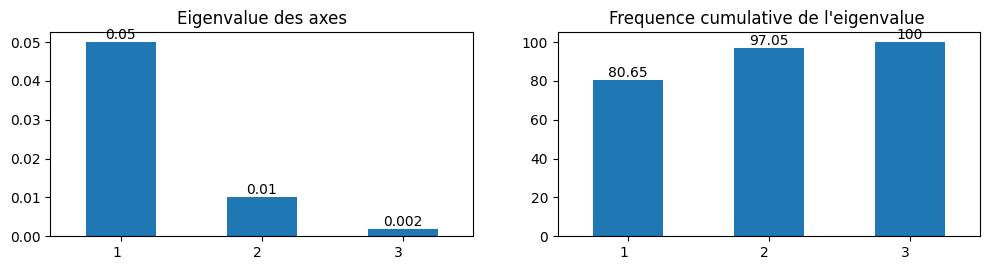

In [25]:
eig = pd.DataFrame(afc.eig_)

r1 = round(eig.iloc[0], 3)
r2 = round(eig.iloc[2], 2)
s=list(range(1,len(r1)+1))
r1.index=s
r2.index=s

# https://www.statology.org/pandas-subplots/
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,3))

ax1 = r1.plot(kind='bar', ax=axes[0], title='Eigenvalue des axes')
ax2 = r2.plot(kind='bar', ax=axes[1], title="Frequence cumulative de l'eigenvalue ")


ax1.bar_label(ax1.containers[0])
ax2.bar_label(ax2.containers[0])


# Met les valeurs xticks en vertical
fig.autofmt_xdate(rotation=0)
plt.show()

NB: la valeur propre des axes (eigenvalue) est la valeur de la variance exprimée par ce axe. Il s'agit donc d'une portion du phi-2, i.e. du chi-2 divisé par le nombre d'individus de la population. 100% de la variance équivaut au phi-2.
<br/>

## Graphiques et interprétation du premier plan factoriel

### Diagramme des résidus pondérés

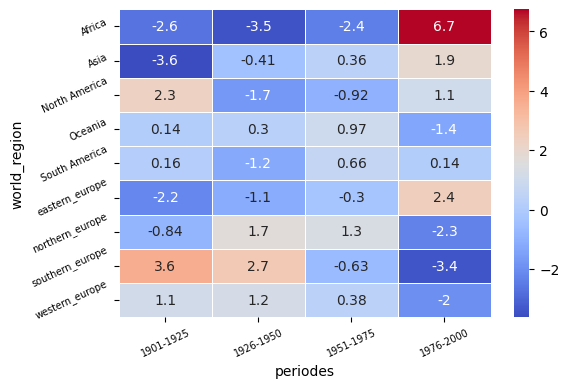

In [35]:
### Résidus pondérés (avec le signe)
### Doc. :
#   Rakotomalala, p.240
residus_ponderes = (round((D.values-dfe)/np.sqrt(dfe),2))
residus_ponderes.columns= D.columns
residus_ponderes.index=D.index


fig, ax = plt.subplots(figsize=(6,4))

# Sample figsize in inches
g = sns.heatmap(residus_ponderes, annot=residus_ponderes, cmap="coolwarm", linewidths=.5, ax=ax)
labelsx = residus_ponderes.columns
labelsy = residus_ponderes.index
xt = g.set_xticklabels(labelsx, rotation=25, fontsize=7)
yt = g.set_yticklabels(labelsy, rotation=25, fontsize=7)





**Théorie - Diagramme des résidus pondérés**

Un diagramme de résidus pondérés est utile pour analyser les associations entre les modalités de variables dans une table de contingence et permettent de mettre en évidence les divergences entre les fréquences observées et attendues.

* **Les résidus pondérés positifs** indiquent que la fréquence
observée est supérieure à la fréquence attendue sous l'hypothèse nulle. Cela signifie qu'il y a un excès de cas dans cette cellule de la table de contingence.

* **Les résidus pondérés négatifs** indiquent que la fréquence observée est inférieure à la fréquence attendue sous l'hypothèse nulle. Cela signifie qu'il y a moins de cas que prévu dans cette cellule de la table de contingence.

* **Les résidus pondérés proches de zéro** indiquent que la fréquence observée est similaire à la fréquence attendue sous l'hypothèse nulle. Cela signifie qu'il n'y a pas de différence notable entre les fréquences observées et attendues dans cette cellule.

**Commentaire**

On observe peu de changements drastiques entre les nationalités des créateurs.trices de mode entre les différentes générations. Les seules régions où l'on remarque des changements notables sont l'Afrique, le Sud de l'Europe et, dans une moindre mesure, l'Asie.

Les effectifs de créateurs.trices de mode augmentent drastiquement en ce qui concerne l'Afrique pour la période 1976-2000. Toutefois, attention à la faiblesse des effectifs pour la période 1901-1925 qui peut avoir contribué à augmenté cette tendance.

Les effectifs de l'Europe du Sud augmentent dans la première moitié du 20e siècle puis déclinent, surtout à partir de 1976.

Pour l'Asie, on constate qu'il y a moins de créateurs.trices de mode au début du 20e siècle et que les effectifs augementent à partir des années 1950.



### Analyse factorielle

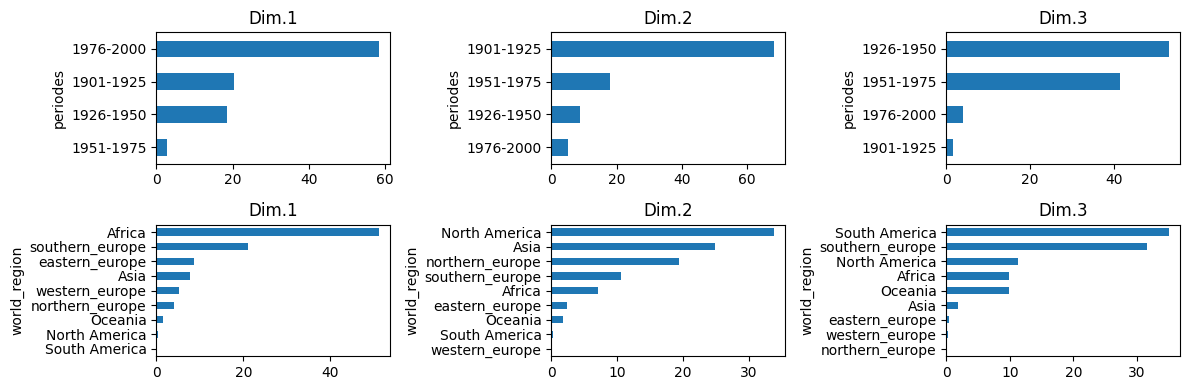

In [27]:
# Informations sur les contributions des colonnes
df = afc.col_topandas()[['col_contrib_dim1',
                         'col_contrib_dim2',
                         'col_contrib_dim3']]

r1 = df.iloc[:,0]
r2 = df.iloc[:,1]
r3 = df.iloc[:,2]

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12,4))

r1.sort_values().plot(kind='barh', ax=axes[0,0], title='Dim.1')
r2.sort_values().plot(kind='barh', ax=axes[0,1], title='Dim.2')
r3.sort_values().plot(kind='barh', ax=axes[0,2], title='Dim.3')

### Rows
df = afc.row_topandas()[['row_contrib_dim1',
                         'row_contrib_dim2',
                         'row_contrib_dim3']]
r1 = df.iloc[:,0]
r2 = df.iloc[:,1]
r3 = df.iloc[:,2]

r1.sort_values().plot(kind='barh', ax=axes[1,0], title='Dim.1')
r2.sort_values().plot(kind='barh', ax=axes[1,1], title='Dim.2')
r3.sort_values().plot(kind='barh', ax=axes[1,2], title='Dim.3')

plt.tight_layout()
plt.show()


### Carte factorielle

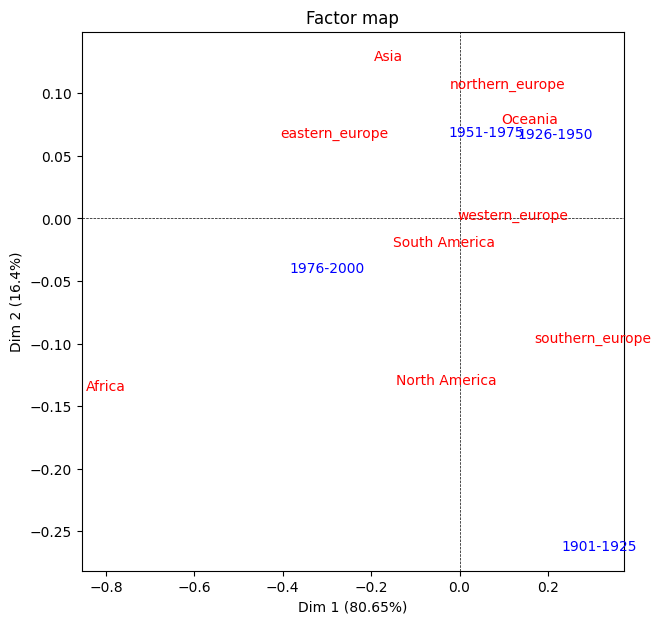

In [28]:
# Représentation simultanée, avec amplification
afc.mapping(num_x_axis=1,num_y_axis=2,figsize=(7,7))

**Commentaire**

On constate que l'Amérique du Nord, du Sud, le Nord de l'Europe et l'Europe de l'Ouest ne varient presque pas au fil des générations ( les effectifs de créateurs.trices de mode restent stables). En effet il sont placé presque à 0 sur l'axe des x qui vaut 80% de la variance.


On voit que l'Afrique est alligné avec la génération 1976-2000 puisqu'on l'a vu avec les résidus pondérés c'est dans cet génération que les effectifs augmentent considérablement. Idem pour l'Europe du Sud et la période 1901 et 1925.

On voit que les effectifs de l'Asie et de l'Europe de l'Est évoluent aussi après 1950.


## Représenter l'autre plan factoriel

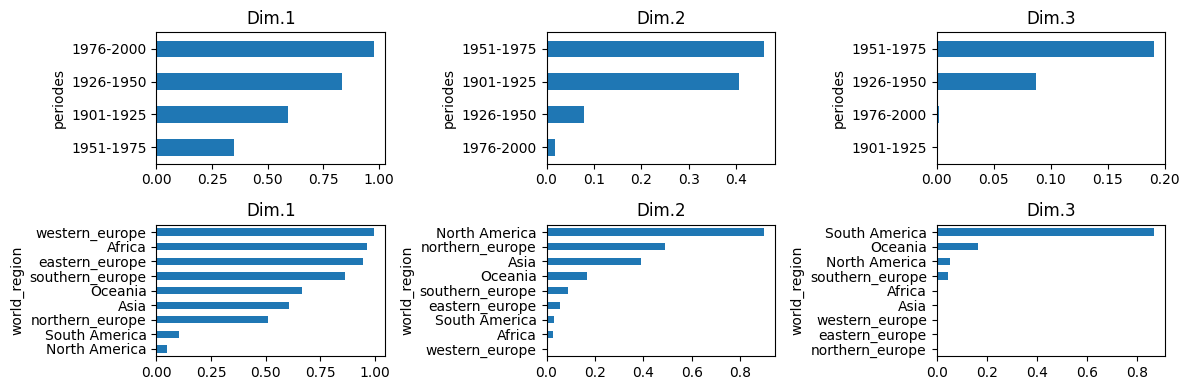

In [29]:
### Informations sur les cosinus carrés. Ces valeurs expriment
# la qualité de représentation d'une modalité sur l'axe correspondant

### Colonnes
df = afc.col_topandas()[['col_cos2_dim1',
                         'col_cos2_dim2',
                         'col_cos2_dim3']]

r1 = df.iloc[:,0]
r2 = df.iloc[:,1]
r3 = df.iloc[:,2]

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12,4))

r1.sort_values().plot(kind='barh', ax=axes[0,0], title='Dim.1')
r2.sort_values().plot(kind='barh', ax=axes[0,1], title='Dim.2')
r3.sort_values().plot(kind='barh', ax=axes[0,2], title='Dim.3')

### Lignes
df = afc.row_topandas()[['row_cos2_dim1',
                         'row_cos2_dim2',
                         'row_cos2_dim3']]
r1 = df.iloc[:,0]
r2 = df.iloc[:,1]
r3 = df.iloc[:,2]

r1.sort_values().plot(kind='barh', ax=axes[1,0], title='Dim.1')
r2.sort_values().plot(kind='barh', ax=axes[1,1], title='Dim.2')
r3.sort_values().plot(kind='barh', ax=axes[1,2], title='Dim.3')

plt.tight_layout()
plt.show()

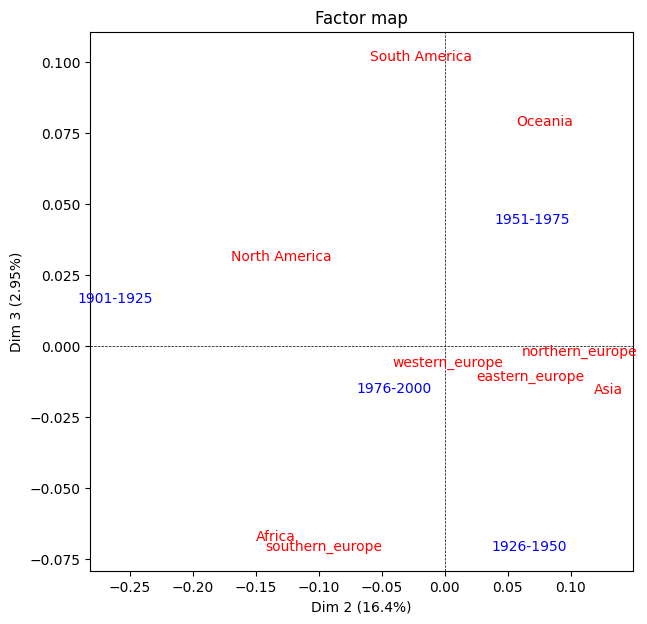

In [30]:
# Représentation simultanée, avec amplification
afc.mapping(num_x_axis=2,num_y_axis=3,figsize=(7,7))

**Commentaire**

On voit que les effectifs de l'Europe de l'Ouest et de l'Amérique du Sud stagnent.


On remarque que les changements d'effectifs de l'Amérique du Nord sont liés à la génération 1901-1925( en effet dans le diagramme des résidus pondérés, on observe qu'ils augmentent un peu).

les changements d'effectifs de l'Afrique et de l'Europe du Sud sont liés à la génération 1976-2000 (augmentation pour l'Afrique et déclin pour l'Europe du Sud, comme nous l'avons vu avec les résidus pondérés)

Les changements d'effectifs pour l'Océanie se situent à la génération 1951-1975.


